In [4]:
import pandas as pd
from src.utility import get_root
import os

file_path = os.path.join(get_root(), "adam_variants_metrics.xlsx")
df = pd.read_excel(file_path)
df.head()

,Dataset,Model,Optimizer,Epoch,Time(s),VRAM(MB),RAM(MB),Train_Loss,Train_Acc,Train_F1,Val_Loss,Val_Acc,Val_F1
0,CIFAR10,ResNet18,Adam,1,45.730279,1830,5170.550781,1.461876,0.476125,0.473262,1.281768,0.5356,0.529542
1,CIFAR10,ResNet18,Adam,2,43.597776,1830,5172.195312,1.051440,0.626100,0.624620,1.098566,0.6173,0.614736
2,CIFAR10,ResNet18,Adam,3,47.103150,1830,5172.621094,0.863780,0.694675,0.694101,1.029244,0.6383,0.640555
3,CIFAR10,ResNet18,Adam,4,41.593714,1830,5172.761719,0.715669,0.746425,0.745754,1.145295,0.6176,0.627760
4,CIFAR10,ResNet18,Adam,5,42.749735,1830,5172.789062,0.587369,0.791300,0.791066,1.079515,0.6541,0.653204


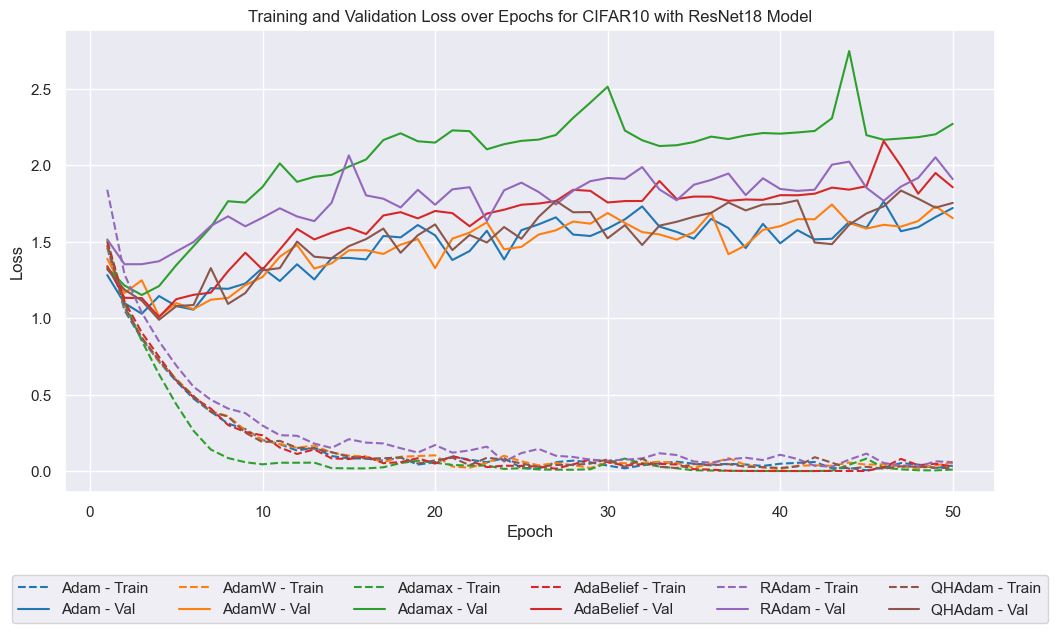

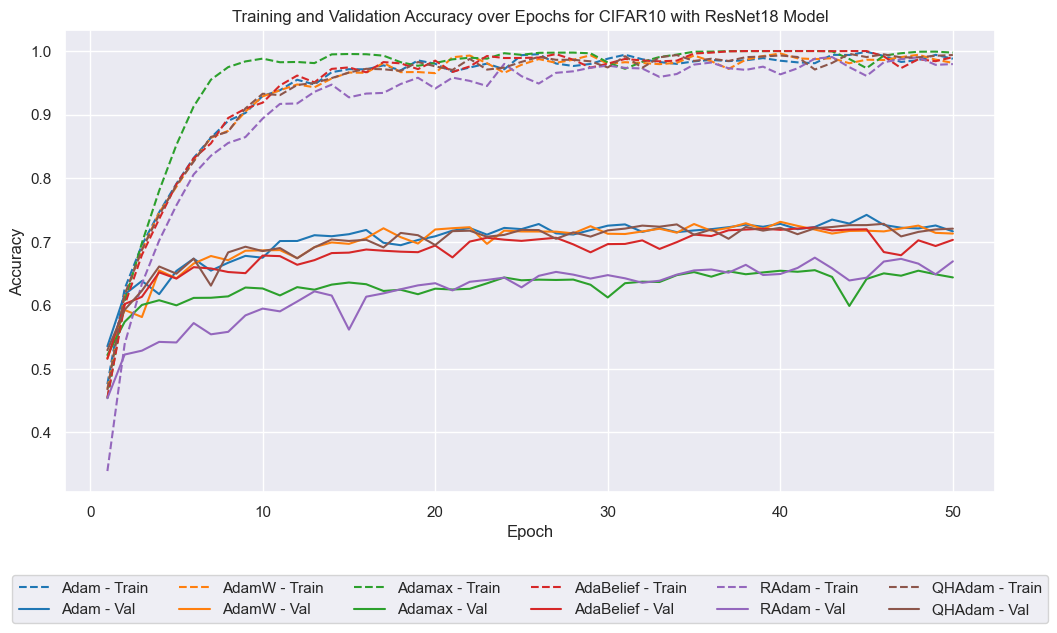

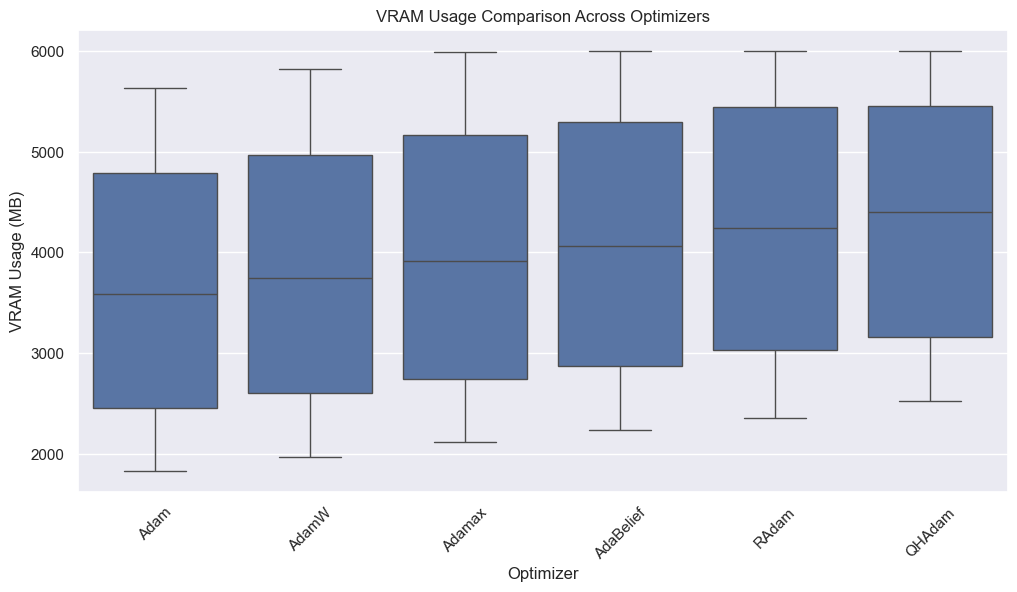

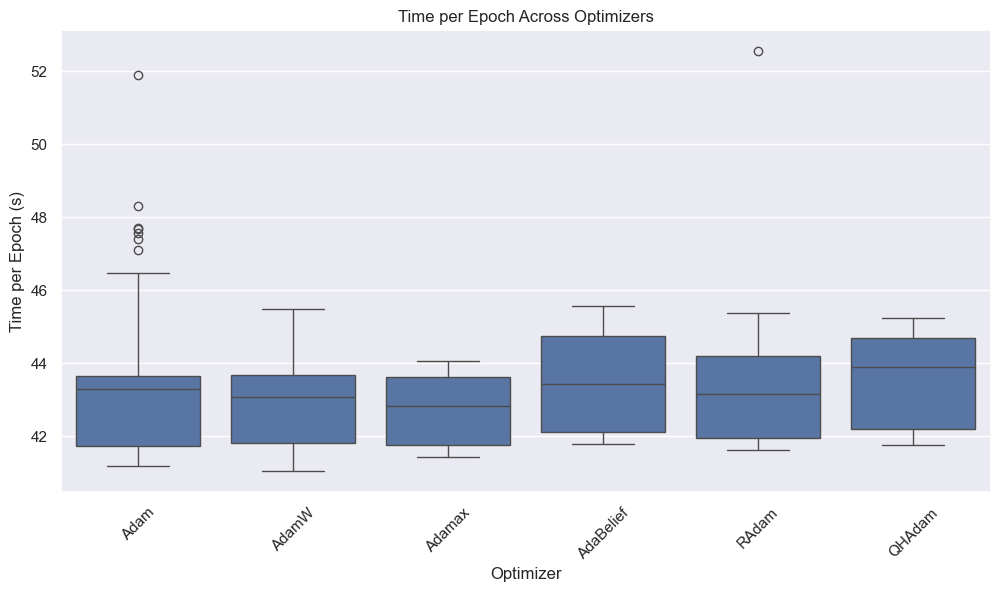

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

sns.set(style="darkgrid")

optimizers = df["Optimizer"].unique()
colors = itertools.cycle(sns.color_palette("tab10", len(optimizers)))

cifar10_resnet_df = df[(df["Dataset"] == "CIFAR10") & (df["Model"] == "ResNet18")]

plt.figure(figsize=(12, 6))
for opt, color in zip(optimizers, colors):
    subset = cifar10_resnet_df[cifar10_resnet_df["Optimizer"] == opt]
    plt.plot(subset["Epoch"], subset["Train_Loss"], label=f"{opt} - Train", linestyle="dashed", color=color)
    plt.plot(subset["Epoch"], subset["Val_Loss"], label=f"{opt} - Val", color=color)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs for CIFAR10 with ResNet18 Model")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=6)
plt.show()

plt.figure(figsize=(12, 6))
colors = itertools.cycle(sns.color_palette("tab10", len(optimizers)))
for opt, color in zip(optimizers, colors):
    subset = cifar10_resnet_df[cifar10_resnet_df["Optimizer"] == opt]
    plt.plot(subset["Epoch"], subset["Train_Acc"], label=f"{opt} - Train", linestyle="dashed", color=color)
    plt.plot(subset["Epoch"], subset["Val_Acc"], label=f"{opt} - Val", color=color)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy over Epochs for CIFAR10 with ResNet18 Model")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=6)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x="Optimizer", y="VRAM(MB)", data=df)
plt.xlabel("Optimizer")
plt.ylabel("VRAM Usage (MB)")
plt.title("VRAM Usage Comparison Across Optimizers")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x="Optimizer", y="Time(s)", data=df)
plt.xlabel("Optimizer")
plt.ylabel("Time per Epoch (s)")
plt.title("Time per Epoch Across Optimizers")
plt.xticks(rotation=45)
plt.show()


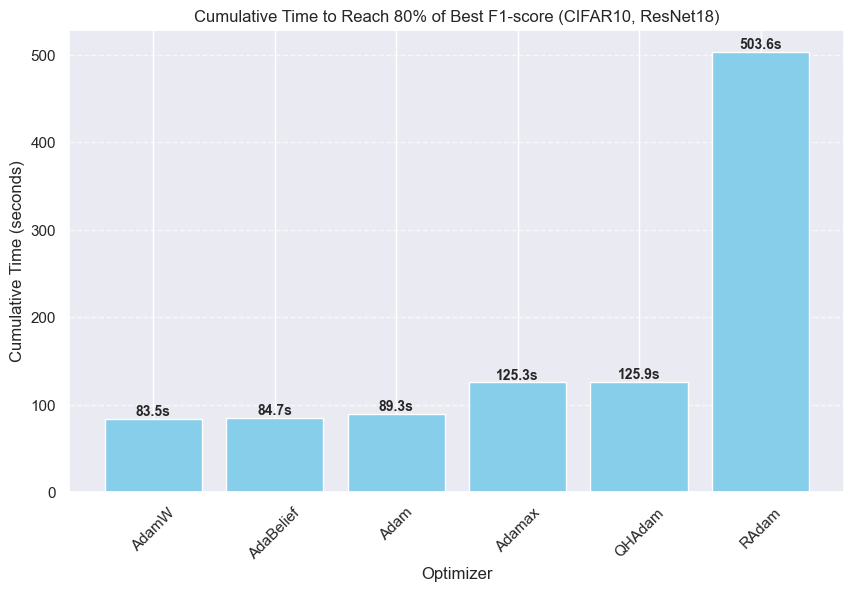

In [27]:
# Filter for CIFAR10 and ResNet18
cifar10_resnet_df = df[(df["Dataset"] == "CIFAR10") & (df["Model"] == "ResNet18")]

# Find the best overall F1-score
best_overall_f1 = cifar10_resnet_df["Val_F1"].max()
threshold_f1 = 0.8 * best_overall_f1

# Find cumulative time taken by each optimizer to reach 80% of best F1-score
optimizers = cifar10_resnet_df["Optimizer"].unique()
time_to_threshold = {}

for opt in optimizers:
    opt_df = cifar10_resnet_df[cifar10_resnet_df["Optimizer"] == opt].sort_values(by="Epoch")
    opt_df["Cumulative_Time"] = opt_df["Time(s)"].cumsum()  # Accumulate time over epochs
    
    reached = opt_df[opt_df["Val_F1"] >= threshold_f1]
    
    if not reached.empty:
        time_to_threshold[opt] = reached.iloc[0]["Cumulative_Time"]  # First time reaching threshold

# Convert to DataFrame for plotting
time_df = pd.DataFrame(list(time_to_threshold.items()), columns=["Optimizer", "Cumulative Time to 80% Best F1"])
time_df = time_df.sort_values(by="Cumulative Time to 80% Best F1")

# Plot the results
plt.figure(figsize=(10, 6))
bars = plt.bar(time_df["Optimizer"], time_df["Cumulative Time to 80% Best F1"], color="skyblue")
plt.ylabel("Cumulative Time (seconds)")
plt.xlabel("Optimizer")
plt.title("Cumulative Time to Reach 80% of Best F1-score (CIFAR10, ResNet18)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add text labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.1f}s", ha='center', va='bottom', fontsize=10, fontweight="bold")

plt.show()
